<br>
<center style="color:#180090; font-weight: bold; font-size: 3em">Esercitazione 4</center><br>
<center style="color:#555555; font-size: 2em; margin-bottom: 0.2cm;">Francesco Righini</center>
<center style="color:#555555; font-size: 1.5em">(931984)</center>

In [1]:
# importazione librerie
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
params = {'legend.fontsize': 'x-large', 'figure.figsize': (10, 6), 'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

<div style="color:#180090; font-size: 0.9cm; padding-top: 1em; font-weight:bold;">Esercizio 1</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 1</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Implementare il codice di dinamica molecolare inserendo la possibilità di riprendere una simulazione da dove era interrotta, ossia eseguire una nuova simulazione ma senza dover attraversare il transiente di assestamento iniziale.
</div>

In [2]:
# impostazione generale di labels, colori, nomi dei parametri...
# definisco qua due funzioni che sappiano come disegnare i grafici con e senza barre d'errore.
# In questo modo nel notebook le celle in cui eseguo la visualizzazione grafica sono più corte.

labels = ["","velocità mai riscalate","velocità riscalate 8 volte","ripresa senza riequilibrare","ripresa a temperatura maggiore\ncon una riscalatura","ripresa a temperatura maggiore\ncon 9 riscalature","dati_6","dati_7","dati_8"]
colors = ["","#43b1cc","#de9b3e","#aede3e","#bb3ede","#471fa3","#FF5555","#55FF55","#5555FF"]
parametri = ["etot","epot","ekin","temp"]
titolo = ["Energia Totale per particella", "Energia Potenziale per particella", "Energia Cinetica per particella", "Temperatura"]
SI_const = [120*1.381e-23, 120*1.381e-23, 120*1.381e-23, 120] # per passare da valori adimensionali a valori dimensionali.

def disegna_funzioni(casi,SI=False):
    
    if (isinstance(casi, int)):
        casi = np.array([casi])
    
    n = len(casi)
    
    fig, axs = plt.subplots(2,2,figsize=(14,14))

    if (SI):
        costanti = SI_const
        aggiunta = ["[J]","[J]","[J]","[K]"]
    else:
        costanti = [1,1,1,1]
        aggiunta = ["[r.u.]","[r.u.]","[r.u.]","[r.u.]"]
    
    color_rand = np.random.random_sample((n, 3))
    
    for k in range (len(parametri)):
        ax = axs.flat[k]

        valori = [[] for _ in range(n)]

        for i in range(n):
            valori[i] = np.loadtxt("results/output_"+parametri[k]+"_"+str(casi[i])+".dat")

        x = np.arange(len(valori[0]))+1 # una per tutte, tanto sono lunghi uguali

        for i in range(n):
            if (casi[i] < len(labels)):
                etichetta = labels[casi[i]]
                colore = colors[casi[i]]
            else:
                etichetta = "valori "+str(casi[i])
                colore =color_rand[i]
            ax.plot(x,costanti[k]*valori[i],label=etichetta,color=colore)

        ax.set(xlabel=r'timestep/10', ylabel=titolo[k]+" "+aggiunta[k], title=titolo[k])
        ax.grid()
        ax.legend()

    return


def disegna_funzioni_errori(caso,label,color,SI=False):
    
    fig, axs = plt.subplots(2,2,figsize=(14,14))
    
    if (SI):
        costanti = SI_const
        aggiunta = ["[J]","[J]","[J]","[K]"]
    else:
        costanti = [1,1,1,1]
        aggiunta = ["[r.u.]","[r.u.]","[r.u.]","[r.u.]"]
    
    
    for k in range (len(parametri)):
        ax = axs.flat[k]
        
        valori, sigma = np.loadtxt("results/output_"+parametri[k]+"_blocchi_"+str(caso)+".dat", usecols=(0,1), delimiter=' ', unpack='true')

        x = np.arange(len(valori))+1 # una per tutte, tanto sono lunghi uguali

        ax.errorbar(x,costanti[k]*valori,yerr=costanti[k]*sigma,label=label,color=color)
        
        ax.set(xlabel=r'#blocchi', ylabel=titolo[k]+" "+aggiunta[k], title=titolo[k])
        ax.grid()
        ax.legend()

    return

<div style="font-size: 0.43cm;">
Il codice di dinamica molecolare utilizzato e implementato per questo notebook richiede sempre in input una configurazione spaziale iniziale.<br><br>
Le altre informazioni necessarie a identificare uno stato fisico sono le velocità delle particelle. Se queste non vengono fornite al programma come input, vengono generate in modo randomico in base alla temperatura desiderata (la temperatura, infatti, è legata all'energia cinetica -e quindi alla velocità- delle particelle tramite la relazione $E_{k}=\frac{3}{2} N k_B T$).<br><br>
Nella simulazione 1 (azzurrina) si è presa come condizione iniziale sulle posizioni per le $108$ particelle un reticolo fcc; le velocità iniziali sono state invece "inventate" per avere temperatura ridotta $T^*=0.9$.
</div>

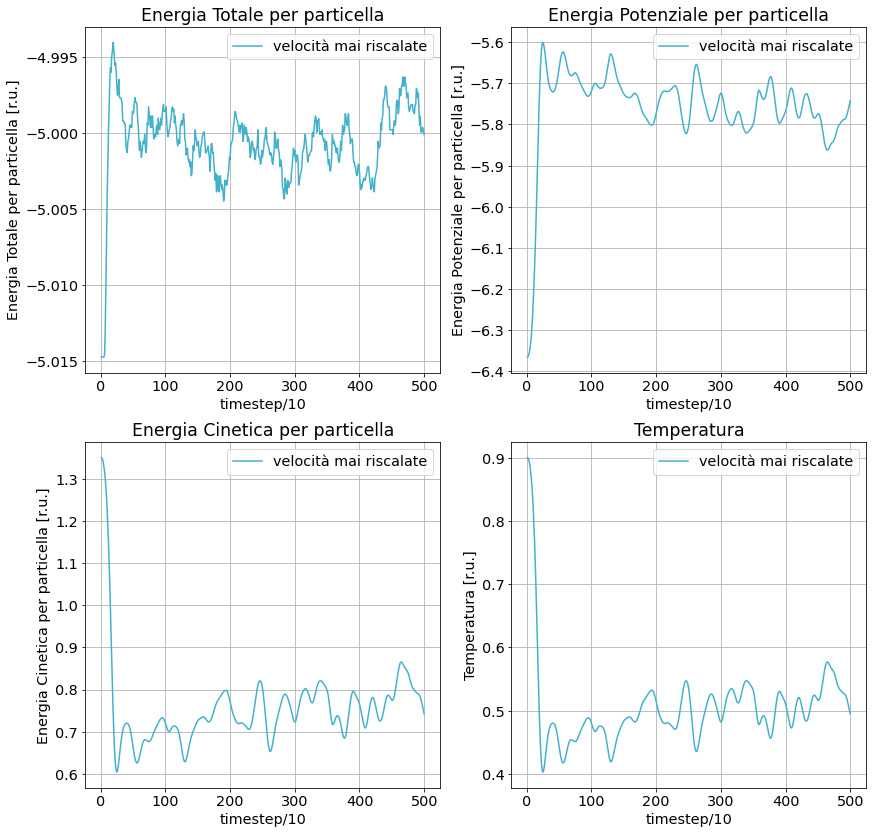

In [3]:
disegna_funzioni(1)

<div style="font-size: 0.43cm;">
La configurazione iniziale, però, potrebbe non essere una situazione di equilibrio. Questo è esattamente ciò che accade nella simulazione 1: all'inizio della simulazione, più precisamente nei primi $200$ timestep (ossia nei primi $20$ timestep/10), si notano delle brusche variazioni nelle variabili termodinamiche del sistema.<br><br>
Per questo motivo, prima di analizzare il sistema, si vuole che esso abbia raggiunto l'equilibrio termodinamico. Per porsi in questa condizione basta semplicemente far evolvere il sistema nel tempo: l'ergodicità del sistema garantisce che si tenda ad una situazione di equilibrio.<br><br>
Come si vede però nei grafici della simulazione 1, la temperatura all'equilibrio non corrisponde alla temperatura desiderata (ossia quella "impostata" all'inizio della simulazione $T^*=0.9$).<br>
Per giungere all'equilibrio termodinamico alla temperatura desiderata, bisogna sì far evolvere il sistema lasciandolo giungere all'equilibrio, ma bisogna anche "aggiustare", ossia riscalare ripetutamente, le velocità delle particelle per riportare il sistema alla temperatura desiderata.<br><br>
La simulazione 2 (arancione) ha stesse condizioni iniziali della simulazione 1. La differenza è che per $8$ volte a distanza di $500$ timestep, le velocità vengono riscalate per adeguarsi alla temperatura richiesta.
</div>

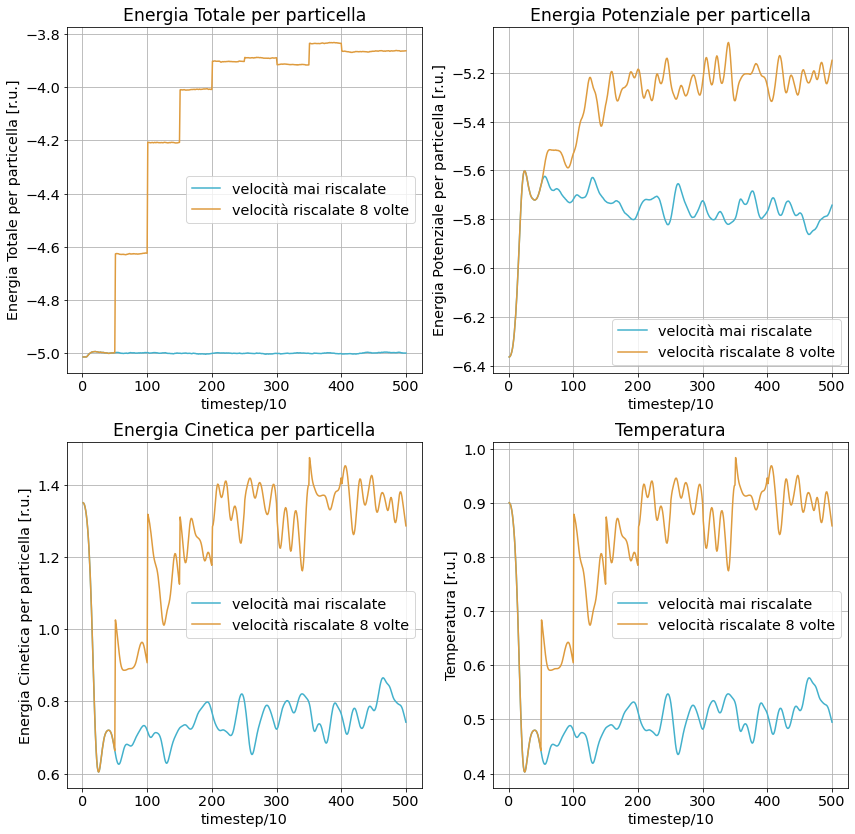

In [4]:
disegna_funzioni((1,2))

<div style="font-size: 0.43cm;">
Il risultato è un sistema in equilibrio: dopo i primi $8 \times 500 = 4000$ timestep, il sistema viene lasciato libero di assestarsi ulteriormente per altri $1000$ timestep, in cui non si evincono drift sistematici delle variabili termodinamiche. Inoltre, la temperatura del sistema oscilla attorno alla temperatura desiderata.<br><br>
Conoscere le posizioni e le velocità di ogni particella di un sistema ormai equilibrato è molto utile per poter far cominciare delle simulazioni senza dover riattraversare il transiente di equilibrazione iniziale.
<br><br>
La simulazione 2 salva su file le posizioni delle particelle nelle configurazioni degli ultimi due timestep. La simulazione 3 (verdina) prende come input questi due file, ottenendo quindi le posizioni iniziali delle particelle e (valutando lo spostamento di ogni particella nell'ultimo $dt$ della simulazione 3) le rispettive velocità iniziali.
    
    
</div>

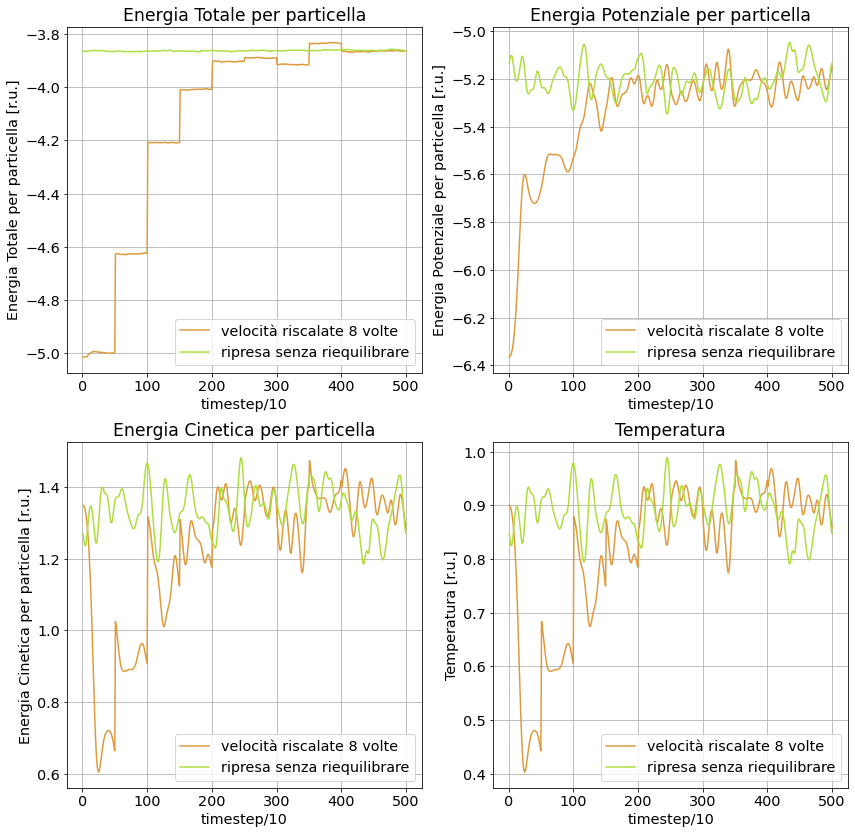

In [5]:
disegna_funzioni((2,3))

<div style="font-size: 0.43cm;">
Fatta eccezione per la prima parte in cui la simulazione 2 è in fase di equilibrazione e riscalamento, le due simulazioni offrono misure di grandezze termodinamiche compatibili. Il vantaggio è che nella simulazione 3 non è stato necessario alcun riscalamento delle velocità nè alcun periodo di stabilizzazione.
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 2</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Aggiungere inoltre la possibilità di riscalare le velocità delle particelle, in modo da poter prendere come situazione iniziale la situazione finale di una simulazione precedente, anche se quest'ultima è stata eseguita ad una temperatura diversa da quella richiesta nella nuova simulazione.
</div>

<div style="font-size: 0.43cm;">
Si è introdotta inizialmente una funzione che, quando chiamata, riscalasse le velocità istantanee delle particelle per adeguarle alla temperatura richiesta (ossia all'energia cinetica media richiesta). Si è notato che però questo metodo non consentiva di far stabilizzare il sistema ad una energia interna d'equilibrio: ogni riscalamento cambiava e questi cambiamenti non andavano piano piano rimpicciolendosi.<br>
Allora si è pensato di riscalare le velocità non in base alle velocità istantanee nel momento in cui la funzione viene chiamata, ma in base a una media temporale su di esse. Si è visto che le correzioni all'energia totale del sistema sono sempre più piccole man mano che si procede con questo tipo di riscalamenti.<br><br>
Si potrebbe pensare di prendere una configurazione iniziale di posizioni e velocità già equilibrata ad una certa temperatura e riscalare una sola volta le velocità per adattarla ad una nuova temperatura.<br>
In questo modo si può ottenere un sistema termodinamico abbastanza equilibrato fin da subito, ma difficilmente alla temperatura desiderata.<br><br>
La simulazione 4 (lilla) è eseguita partendo dalla condizione finale della simulazione 2 e riscalando soltanto all'inizio le velocità in modo da portarsi a temperatura ridotta $T^*=1.2$.
</div>

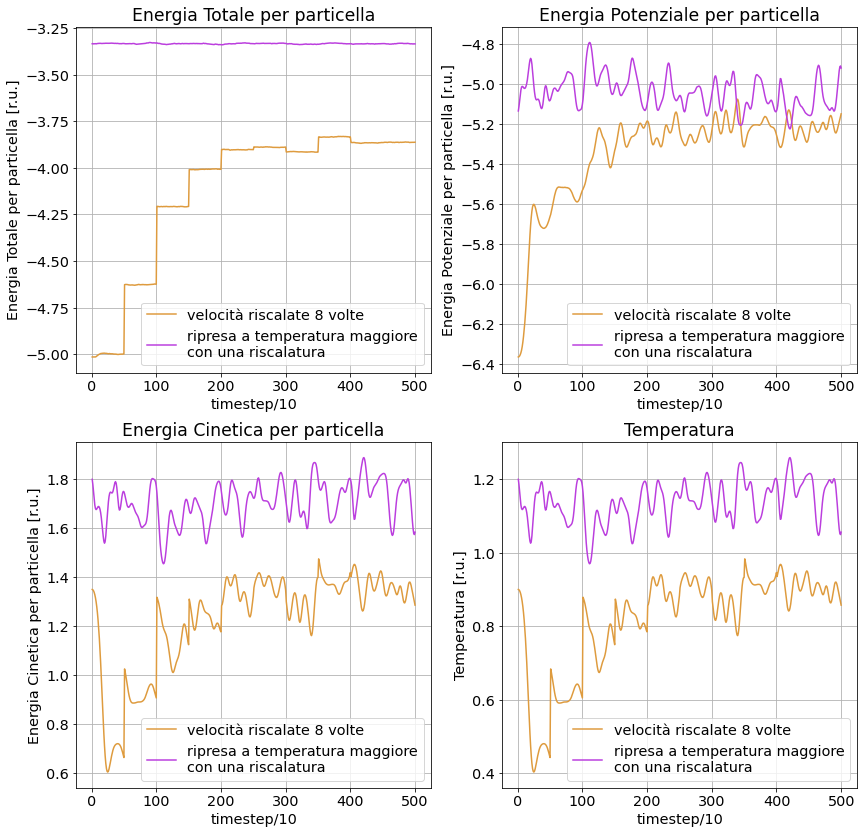

In [6]:
disegna_funzioni((2,4))

<div style="font-size: 0.43cm;">
È evidente che il sistema si porta velocemente ad una situazione di equilibrio, ma ad una temperatura diversa da quella fissata inizialmente.<br><br>
La simulazione 5 (blu) è eseguita anora partendo dalle condizioni finali della simulazione 2, però, a differenza della simulazione 4, le velocità vengono riscalate più volte ($9$ volte a distanza di $500$ timestep) per portarsi alla temperatura ridotta desiderata $T^*=1.2$.
</div>

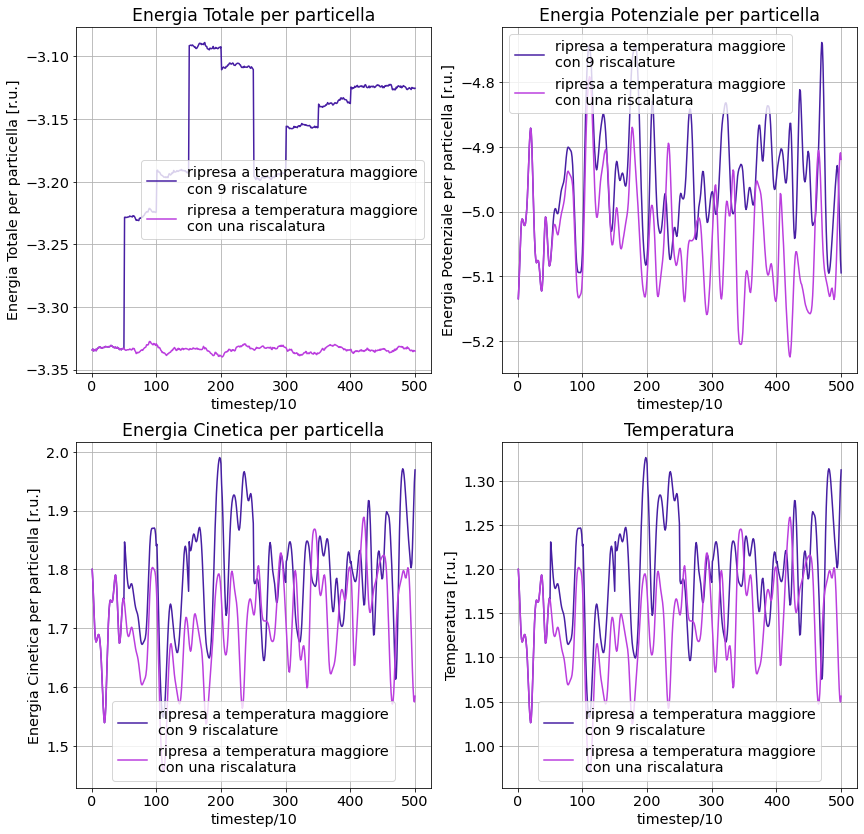

In [7]:
disegna_funzioni((5,4))

<div style="font-size: 0.43cm;">
Dopo $4000$ timestep di nuova equilibrazione, il sistema della simulazione 5 si trova in equilibrio alla temperatura desiderata.
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 3</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Mostrare il transiente iniziale e l'efficacia dell'equilibrazione
</div>

<div style="font-size: 0.43cm;">
In questo specchietto sono riportate sovrapposte:
<ul>
    <li>simulazione 2: [arancione] equilibrazione sistema a $T^*=0.9$ (8 riscalature)</li>    
    <li>simulazione 4: [lilla] ripresa della simulazione 2 a $T^*=1.2$ (1 riscalatura iniziale)</li>    
    <li>simulazione 5: [blu] ripresa della simulazione 2 a $T^*=1.2$ (9 riscalature)</li>    
</ul>
</div>

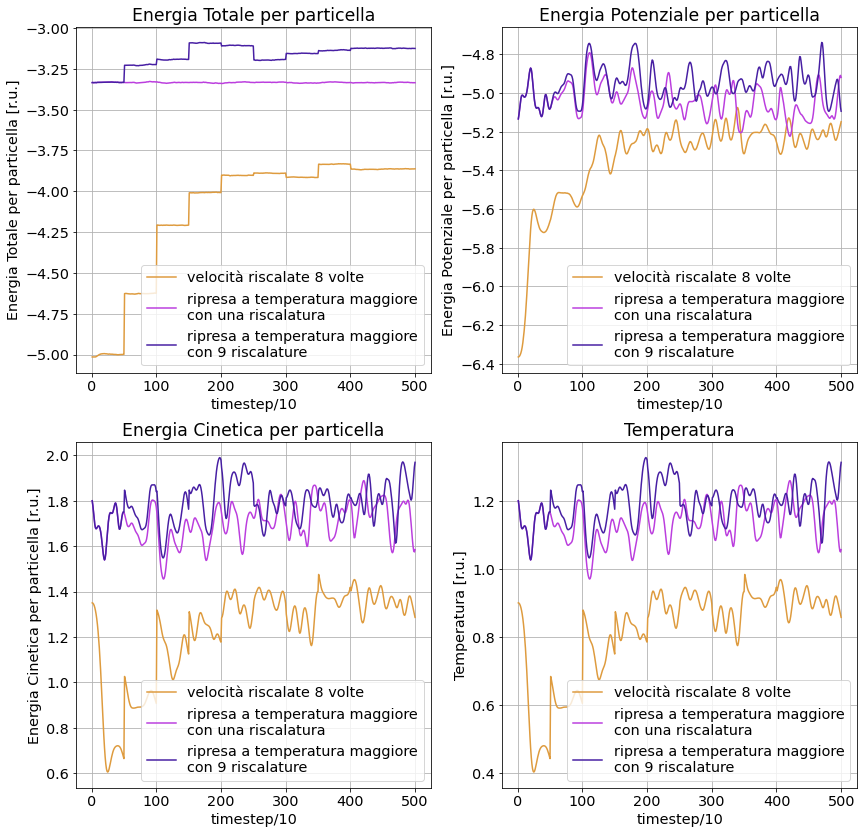

In [8]:
disegna_funzioni((2,4,5))

<div style="color:#180090; font-size: 0.9cm; padding-top: 1em; font-weight:bold;">Esercizio 2</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Implementare il codice di dinamica molecolare inserendo la possibilità di monitorare grandezze medie del sistema, quali l'energia interna, cinetica e potenziale media per particella e la temperatura.
</div>

<div style="font-size: 0.43cm;">
Per calcolare l'energia potenziale di ogni particella bisogna effettuare un ciclo su tutte le coppie di particelle: il potenziale di Lennard-Jones è un potenziale a coppie, ossia che associa un'energia di interazione ad ogni coppia di particelle.<br>
Il calcolo dell'energia cinetica e della temperatura, invece, ha complessità lineare col numero di particelle: per ogni particella si deve valutare il modulo della velocità. L'energia cinetica media per particella è l'energia cinetica totale divisa per il numero di particelle. La temperatura è trovata dall'espressione $T=\frac{2}{3}\frac{E_k}{N k_B}$.
L'energia totale è la somma dell'energia cinetica e potenziale.
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 1</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Dividendo i passi della simulazione in blocchi, mostrare l'andamento dei valor medi delle grandezze in esame e delle loro incertezze in funzione del numero di blocchi.
</div>

<div style="font-size: 0.43cm;">
Le misure delle variabili termodinamiche vengono effettuate ogni 10 timestep. Ogni blocco contiene le medie di $M$ misure delle quattro grandezze termodinamiche in esame.<br><br>
Nella simulazione 8 si è partiti da un sistema già equilibrato alla temeratura ridotta $T^*=1.1$ e si è lasciato evolvere il sistema per $10000$ timestep eseguendo quindi in totale $1000$ misure termodinamiche, raggruppate in $50$ blocchi da $M=20$ misure ciascuno.
</div>

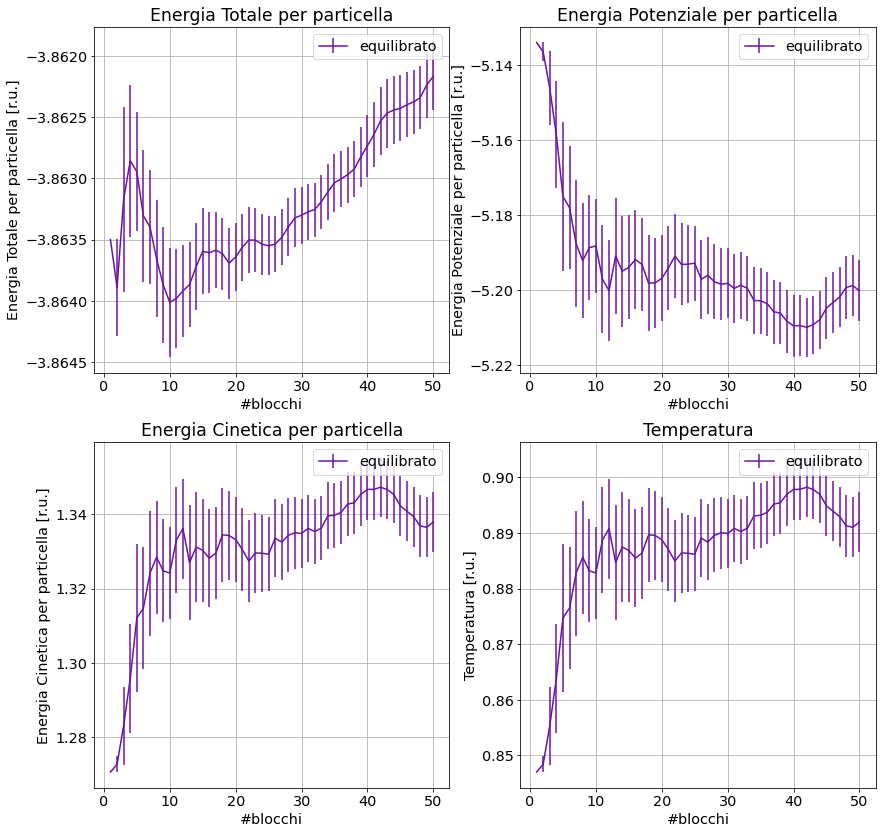

In [9]:
disegna_funzioni_errori(3,"equilibrato","#6912a3")

<div style="font-size: 0.43cm;">
Il fatto che inizialmente le variabili termodinamiche non siano centrate sulle stime finali (e che nemmeno le proprie barre d'errore coprano la stima finale) è probabilmente dovuto a misure troppo addensate nel tempo, e quindi troppo correlate tra loro.<br><br>
Ho lasciato qui questo esempio un po' patologico (ma nemmeno terribile) per giustificare simulazioni molto lunghe e con misure molto distanti nel tempo fatte nella prossima sezione.
</div>

<div style="color:#180090; font-size: 0.9cm; padding-top: 1em; font-weight:bold;">Esercizio 3</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Simulare il modello costruito prendendo in considerazione atomi di Argon di massa $m=39.948\text{ u.m.a.}$ che interagiscono secondo un potenziale di Lenanrd-Jones con parametri $\sigma = 0.34 \text{ nm}$, $\epsilon/k_B = 120 \text{ K}$.
<br>
Per ognuno dei tre casi, mostrare i valori medi e le incertezze dell'energia interna, cinetica e potenziale per particella e della temperatura.
</div>

<div style="font-size: 0.43cm;">
Il programma di simulazione lavora in unità di Lennard-Jones, ossia utilizzando $\sigma$ ed $\epsilon$ come unità di lunghezza e di energia.<br><br>
Per riportare le grandezze in unità del Sistema Internazionale si devono semplicemente riscalare le diverse grandezze:
<ul>
<li>Energie: $E = \epsilon E^*$
<li>Lunghezze: $l = \sigma l^*$
<li>Densità di massa: $\rho = m\sigma^{-3} \rho^*$
<li>Tempi: $t = \sigma\sqrt{\frac{m}{\epsilon}}t^*$
<li>Temperature: $T = \frac{\epsilon}{k_B}T^*$
</ul>
In unità di Lennard-Jones si è utilizzato un tempo di integrazione $dt^*=0.0005$ che, portato in unità del sistema internazionale, corrisponde a $dt = 1.08\times10^{-15} \text{ s}$
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 1</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Simulare lo stato solido utilizzando i parametri:
<ul>
<li>$\rho^\star = 1.1$
<li>$T^\star = 0.8$
<li>$r_c = 2.2$
</ul>
</div>

<div style="font-size: 0.43cm;">
Per eseguire la simulazione sullo stato solido si è eseguita una prima equilibrazione da $10000$ timestep con $20$ riscalature a distanza di $300$ timestep.<br>
Successivamente si è eseguita una simulazione da $30000$ timestep in cui sono state prese $3000$ misure suddivise in $100$ blocchi da $M=30$ misure ciascuno.
</div>

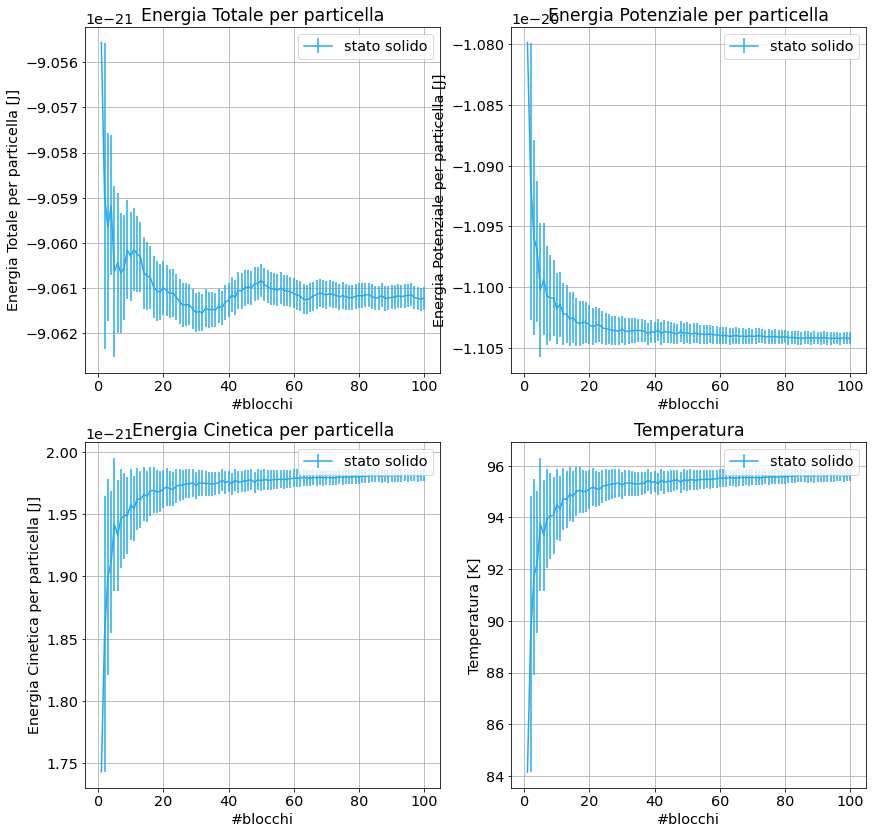

In [10]:
disegna_funzioni_errori(11,"stato solido","#22AAEE",True)

<div style="font-size: 0.43cm;">
L'andamento delle stime delle grandezze termodinamiche è pienamente autoconsistente e, come ci si aspettava, l'incertezza scala col numero di blocchi.<br><br>
il valor medio della temperatura è $95.6 \pm 0.2 \text{ K}$, a quasi due sigma dal valore desiderato $96\text{ K}$.
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 2</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Simulare lo stato liquido utilizzando i parametri:
<ul>
<li>$\rho^\star = 0.8$
<li>$T^\star = 1.1$
<li>$r_c = 2.5$
</ul>
</div>

<div style="font-size: 0.43cm;">
Per eseguire la simulazione sullo stato liquido si è eseguita ancora una prima equilibrazione da $20000$ timestep con $40$ riscalature a distanza di $400$ timestep.<br>
Successivamente si è eseguita una simulazione da $80000$ timestep in cui sono state prese $8000$ misure suddivise in $100$ blocchi da $M=80$ misure ciascuno.
</div>

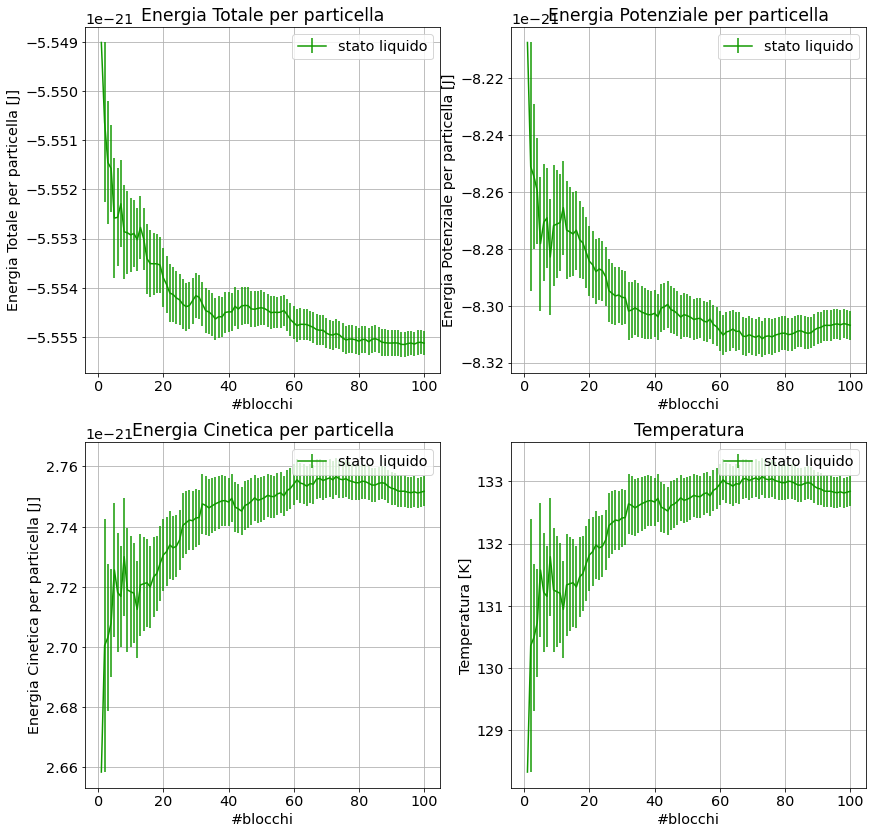

In [11]:
disegna_funzioni_errori(21,"stato liquido","#119900",True)

<div style="font-size: 0.43cm;">
L'andamento delle stime delle grandezze termodinamiche è consistente nel tempo e, come ci si aspettava, l'incertezza scala col numero di blocchi.<br><br>
il valor medio della temperatura è $132.8 \pm 0.2 \text{ K}$, a più di tre sigma dal valore desiderato $132\text{ K}$.
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 3</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Simulare lo stato gassoso utilizzando i parametri:
<ul>
<li>$\rho^\star = 0.05$
<li>$T^\star = 1.2$
<li>$r_c = 5.0$
</ul>
</div>

<div style="font-size: 0.43cm;">
Per eseguire la simulazione sullo stato gassoso si è eseguita una prima equilibrazione da $30000$ timestep con $50$ riscalature a distanza di $500$ timestep.<br>
Successivamente si è eseguita una simulazione da $400000$ timestep in cui sono state prese $40000$ misure suddivise in $80$ blocchi da $M=5000$ misure ciascuno.
</div>

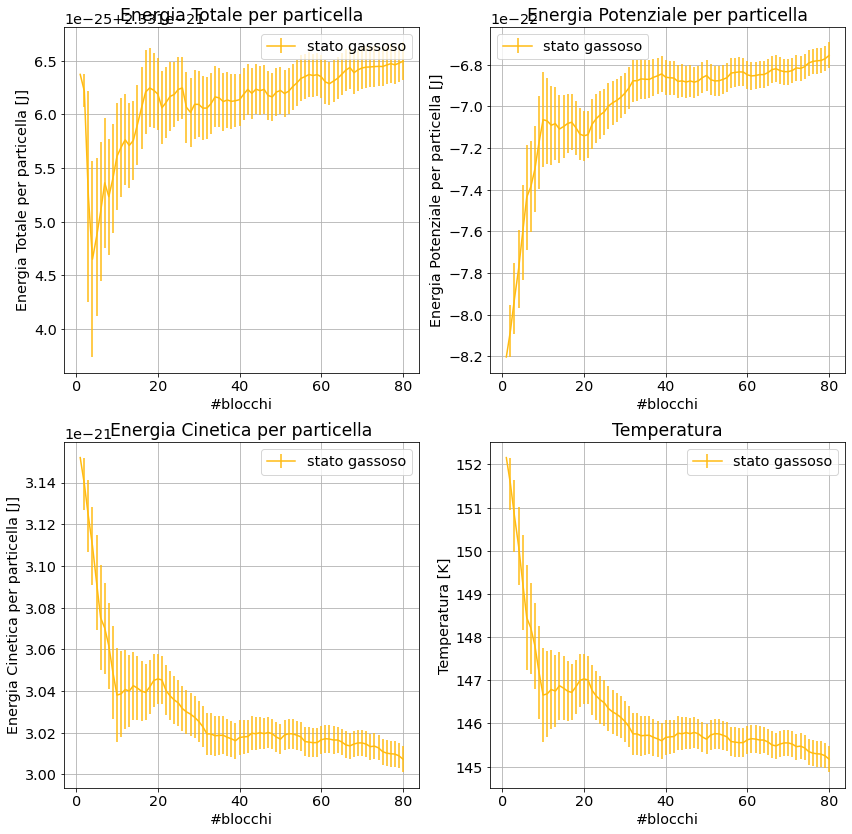

In [12]:
disegna_funzioni_errori(31,"stato gassoso","#FFBB11",True)

<div style="font-size: 0.43cm;">
Nonostante i grandi numeri e le misure molto lontane tra loro, l'andamento delle grandezze termodinamiche è non del tutto consistente nel tempo.<br><br>
Il valor medio della temperatura è $145.2 \pm 0.3 \text{ K}$, distante circa due sigma e mezzo dal valore desiderato $144\text{ K}$.<br><br>
Si dovrebbero ulteriormente diluire nel tempo le misure delle variabili termodinamiche in modo che siano più scorrelate, con conseguente aumento del tempo di calcolo.
</div>